In [1]:
using Revise
using Pkg
Pkg.develop(path="/home/stephenz/stephenz/locaTE.jl")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [10]:
using NPZ
using locaTE
using NearestNeighbors
using Graphs
using GraphSignals
using SparseArrays
using LinearAlgebra

In [3]:
using Plots
using StatsBase

In [4]:
X = npzread("X.npy");
X_pca = npzread("X_pca.npy");
X_umap = npzread("X_umap.npy");
P = npzread("P.npy");
clust = npzread("louvain.npy");
dpt = npzread("dpt.npy");

In [5]:
P = (0.99P + 0.01I);

In [6]:
# construct kNN and Laplacian
kdtree = KDTree(X_pca')
idxs, dists = knn(kdtree, X_pca', 25);
A = spzeros(size(X_pca, 1), size(X_pca, 1));
for (i, j) in enumerate(idxs)
    A[i, j] .= 1.0
end
L = sparse(normalized_laplacian(max.(A, A'), Float64));

In [7]:
expf(x) = I + x + (x^2)/2 

expf (generic function with 1 method)

In [8]:
t = 1.0
# R = expf(-t*Array(L))
# R ./= sum(R; dims = 2);
R = I(size(X, 1));

In [9]:
using Distances
using OptimalTransport
C = Distances.pairwise(SqEuclidean(), X_pca[:, 1:10]')
C ./= mean(C)
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5*mean(C));

In [11]:
# p = Array(R[2500, :])
# scatter(X_umap[sortperm(p), 1], X_umap[sortperm(p), 2], marker_z = sort(p), clim = (0, quantile(p, 0.999)), alpha = 0.25, markerstrokewidth = 0)

In [12]:
P_sp = sparse(P)
QT_sp = sparse(to_backward_kernel(P))
R_sp = sparse(R);

In [13]:
using Discretizers
alg = DiscretizeBayesianBlocks()
disc = locaTE.discretizations_bulk(X; alg = alg);

In [14]:
n_clust = maximum(clust)+1
A_clust = spzeros(size(X, 1), n_clust)
for (i, n) in enumerate(clust)
    A_clust[i, Int(n)+1] = 1;
end
A_clust = Array(A_clust)
A_clust_norm = Array(A_clust ./ sum(A_clust; dims = 1));

In [15]:
R_clust = A_clust_norm' * R;

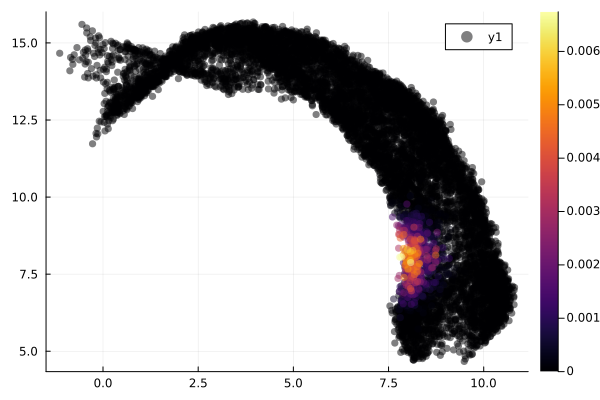

In [25]:
p = R_clust[50, :]
scatter(X_umap[sortperm(p), 1], X_umap[sortperm(p), 2], marker_z = sort(p), markerstrokewidth = 0, alpha = 0.5)

In [ ]:
TE = estimate_TE_cu(X, 1:size(X, 2), 1:size(X, 2), Array(P_sp), Array(QT_sp), R_clust, clusters = A_clust, N_blocks = 4, disc = disc)

Progress:  17%|███████▏                                 |  ETA: 1:06:03

In [27]:
TE_clr = apply_wclr(TE, size(X, 2))
TE_clr[isnan.(TE_clr)] .= 0

0-element view(adjoint(::Matrix{Float64}), CartesianIndex{2}[]) with eltype Float64

In [28]:
TE_clr_full = A_clust * TE_clr;

In [30]:
using CUDA

In [31]:
L_cu = cu(Array(L));
G = fitsp(cu(TE_clr_full), L_cu, λ1 = 25.0, λ2 = 0.001, maxiter = 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:53
[ Info: ΔX = 1.4081804477499065e-6, ΔZ = 0.0001568747482466916, ΔW = 0.0001674654798184197
[ Info: tr(X'LX) = 2.996224234215236, 0.5|X-G|^2 = 10.95263225022382, |X|1 = 67432.77030433134


In [32]:
npzwrite("G_locate.npy", Array(G))
npzwrite("TE.npy", TE)
npzwrite("TE_clr.npy", TE_clr)

In [34]:
TE_full = A_clust * TE;
npzwrite("TE_full.npy", TE_full)